# Seattle Airbnb Open Data Analysis

This data has been downloaded from Kaggle datasets.

### Why choose this data

Seattle is one of the largest metropolis of the Pacific Northwest, and one of the largest and most affluent urban centres in the United States. Seattle is famous for Starbucks and overall coffee culture, grunge music scene, the Seahawks, the Space Needle, Pike Place Market, headquarters of a lot of the tech industry (including both Amazon and Microsoft), hiking, kayaking, and general outdoors lifestyle.

Since it is one of famous tourist destination in U.S, this is elaborative data for Seattle's all Airbnb bookings and property for year 2016 and lot of business questions can be answered from this data. 

For example some new property want to list their property and want to understand how property should be priced and what factors can affect price, this dataset can be used to get some useful insights.

Another useful utility for this dataset can be for someone who want is looking to enter hospitality business and want to understand what are the hot locations and what location have potential to be next hot location and what are the amenities and type of property that can get more price and occupancy.



### What is this data?

The following Airbnb activity is included in this Seattle dataset:

- Listings, including full descriptions and average review score
- Reviews, including unique id for each reviewer and detailed comments
- Calendar, including listing id and the price and availability for that day

### Downloading necessary packages

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from folium import Map
from folium.plugins import HeatMap
import folium

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Downloading the files from CSV files into dataframe in this session

In [2]:
seattle_cal = pd.read_csv("Data/Seattle/calendar.csv")
seattle_list = pd.read_csv("Data/Seattle/listings.csv")
seattle_rev = pd.read_csv("Data/Seattle/reviews.csv")

Let's try to understand each dataset one by one and gain understanding

### Dataset 1 - Reviews

In [3]:
seattle_rev.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


##### No of unique listing_ids

In [4]:
seattle_rev.listing_id.nunique()

3191

##### Maximum and Minimum date range

In [5]:
print("Data Range of review data starts from ",seattle_rev.date.min()," to ",seattle_rev.date.max())

Data Range of review data starts from  2009-06-07  to  2016-01-03


##### No of unique review_id

In [6]:
seattle_rev.reviewer_id.nunique()

75730

### Dataset 2 - Calendar

In [7]:
seattle_cal

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
...,...,...,...,...
1393565,10208623,2016-12-29,f,NaN
1393566,10208623,2016-12-30,f,NaN
1393567,10208623,2016-12-31,f,NaN
1393568,10208623,2017-01-01,f,NaN


In [8]:
seattle_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


##### Price Column

Price Column has dollar sign due to which it is being treated as object. 

It need to be fixed so that it is treated as numeric

In [9]:
seattle_cal.loc[:,'price'] = seattle_cal['price'].str.replace("$",'',regex=True).str.replace(",","",regex=True).astype('float')

In [10]:
seattle_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   listing_id  1393570 non-null  int64  
 1   date        1393570 non-null  object 
 2   available   1393570 non-null  object 
 3   price       934542 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 42.5+ MB


Price is now treated as float now which is great news!!!

#### Lets look at date column range

In [11]:
print("Date ranges from ",min(seattle_cal['date'])," to ",max(seattle_cal['date']))

Date ranges from  2016-01-04  to  2017-01-02


##### Let's look at number of unique number of listing_id

In [12]:
seattle_cal['listing_id'].nunique()

3818

##### Since data is only for 2016, let's create 2 new columns - 'Month' and 'Month_Year'

In [13]:
seattle_cal['month_year'] = seattle_cal['date'].map(lambda x: x[0:7])
seattle_cal['month'] = seattle_cal['date'].map(lambda x: x[5:7])

In [14]:
seattle_cal['month'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12'], dtype=object)

In [15]:
seattle_cal['month_year'].unique()

array(['2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
       '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01'], dtype=object)

##### Column - available means if property was occupied or available. This column can be used to check for how many days out of total days property was occupied. Occupancy can be one parameter to see how property performs and at what time of year occpuancy is highest.

In [16]:
# Creating a occupancy function and checking overall occupancy over entire dataset

def occupancy_func(df):
    """
    Takes dataframe as input
    Checks how many time available == False
    """
    
    occupied = 0
    count = 0
    
    for i in range(len(df)):
        
        if df['available'][i] == 'f':
            occupied += 1
            count += 1
        else:
            occupied += 0
            count += 1
    
    return occupied/count


occupancy_func(seattle_cal)

0.32938998399793334

So overall occupancy is at 33%

To look at occupancy trend at month level, let's create one more additional column

In [17]:
# Creating a new column - occupied which has value 1 if available value is False

seattle_cal['occupied'] = seattle_cal['available'].apply(lambda x: 1 if x == 'f' else 0)

In [18]:
seattle_cal

,listing_id,date,available,price,month_year,month,occupied
0,241032,2016-01-04,t,85.0,2016-01,01,0
1,241032,2016-01-05,t,85.0,2016-01,01,0
2,241032,2016-01-06,f,NaN,2016-01,01,1
3,241032,2016-01-07,f,NaN,2016-01,01,1
4,241032,2016-01-08,f,NaN,2016-01,01,1
...,...,...,...,...,...,...,...
1393565,10208623,2016-12-29,f,NaN,2016-12,12,1
1393566,10208623,2016-12-30,f,NaN,2016-12,12,1
1393567,10208623,2016-12-31,f,NaN,2016-12,12,1
1393568,10208623,2017-01-01,f,NaN,2017-01,01,1


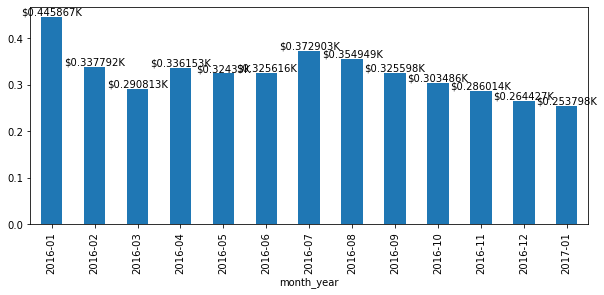

In [19]:
# bar graph showing occupancy for each value of month_year

fig = plt.figure(figsize = (10,4));
ax2 = fig.gca();

occupancy_per_month_year = seattle_cal.groupby(['month_year'])['occupied'].sum()/seattle_cal.groupby(['month_year'])['listing_id'].count()
ax = occupancy_per_month_year.plot(kind='bar',ax=ax2);



for container in ax.containers:
    ax.bar_label(container, fmt='$%gK')

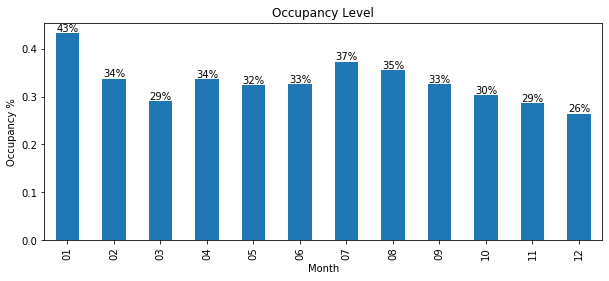

In [20]:
# bar graph showing occupancy for each value of month

fig = plt.figure(figsize = (10,4));
ax2 = fig.gca();

occupancy_per_month = seattle_cal.groupby(['month'])['occupied'].sum()/seattle_cal.groupby(['month'])['listing_id'].count()
ax = occupancy_per_month.plot(kind='bar',ax=ax2);

plt.title('Occupancy Level');
plt.xlabel('Month');
plt.ylabel('Occupancy %');
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:.0%}' for x in container.datavalues])

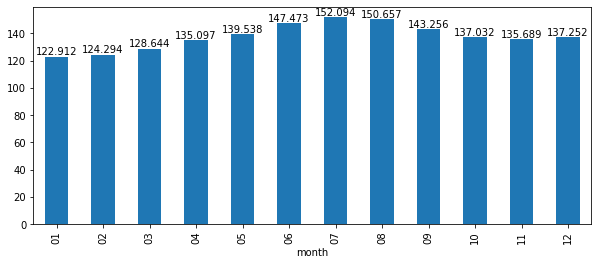

In [21]:
# bar graph showing average price for each value of month

fig = plt.figure(figsize = (10,4));
ax2 = fig.gca();

occupancy_per_month_year = seattle_cal.groupby(['month'])['price'].mean()
ax = occupancy_per_month_year.plot(kind='bar',ax=ax2);



for container in ax.containers:
    ax.bar_label(container)

### Insight 1

#### Occupancy is highest in month of January

#### Another peak occurs in month of July

#### Average Prices peak at month of July and August repesenting months of peak demand


This means that January and July are 2 favourite months for tourists who used Airbnb services. 

Occupancy trend for all month matches with weather trend in Seattle where Temprature is at its peak in month of July and August with one exception of highest occupancy level of 43% in month of January. As Seattle has many technological offices, month of January and February can be the period where people are travelling the most in Seattle for business purposes

## Dataset 3 - Listings

In [22]:
pd.options.display.max_columns = seattle_list.shape[1]
seattle_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [23]:
seattle_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

Adding Occupancy %age for each property

In [24]:
occupancy_list = seattle_cal.groupby(['listing_id'])['occupied'].sum()/seattle_cal.groupby(['listing_id'])['occupied'].count()

occupancy_list_df = occupancy_list.reset_index()

seattle_list = seattle_list.merge(occupancy_list_df,how='left', left_on='id',right_on='listing_id')

#### Data Cleansing Step 1

Price column has type object as it has dollar sign. 

Dollar sign need to be removed convert it into numeric form

In [25]:
seattle_list.loc[:,'price'] = seattle_list['price'].str.replace("$",'',regex=True).str.replace(",","",regex=True).astype('float')

Let's add a variable - price_per_person which is price per person property can accomodate

In [26]:
seattle_list.loc[:,'price_per_person'] = seattle_list['price']/seattle_list['accommodates']

Understanding numeric variables using describe method

In [27]:
seattle_list.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,price,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month,listing_id,occupied,price_per_person
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000,3.818000e+03,3818.000000,3818.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,127.976166,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919,5.550111e+06,0.329390,41.266923
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,90.250022,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348,2.962660e+06,0.347322,20.676221
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,20.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000,3.335000e+03,0.000000,4.750000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,75.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000,3.258256e+06,0.013699,27.500000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,100.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000,6.118244e+06,0.156164,37.500000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,150.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000,8.035127e+06,0.660274,50.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,1000.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000,1.034016e+07,1.000000,275.000000


Certain anomolies found in data

- 'square_feet' is available only for 97 rows so we would discard its further usage
- 'minimum_nights' and 'maximum_nights' have max value 1000 and 100000 which seems to be quite high

#### Data Cleansing Step 2

Investigated and fixing the abnormal high value for 'minimum_nights' and 'maximum_nights'

In [28]:
seattle_list.loc[seattle_list['minimum_nights'] > 30]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,...,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,listing_id,occupied,price_per_person
2107,5056580,https://www.airbnb.com/rooms/5056580,20160104002432,2016-01-04,Soaring Crane Luxury Garden Retreat,Gorgeous professionally-designed 850 square fo...,Welcome to my professionally designed luxury 8...,Gorgeous professionally-designed 850 square fo...,none,"North Beacon Hill is a very diverse, welcoming...","'Tall' visitors: if you're over 6'2"", the show...",A quick 5-minute walk to the Beacon Hill light...,NaN,NaN,https://a0.muscache.com/ac/pictures/77815500/f...,NaN,193689,https://www.airbnb.com/users/show/193689,Eric,2010-08-06,"Seattle, Washington, United States",Schooled in finance and environmental science ...,within an hour,100%,100%,t,https://a1.muscache.com/ac/users/193689/profil...,https://a1.muscache.com/ac/users/193689/profil...,North Beacon Hill,1.0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,"17th Avenue South, Seattle, WA 98144, United S...",North Beacon Hill,North Beacon Hill,Beacon Hill,Seattle,WA,98144,Seattle,"Seattle, WA",US,United States,47.584301,...,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Free Pa...",NaN,99.0,$745.00,"$2,985.00",$100.00,$20.00,2,$0.00,31,365,a week ago,t,30,60,88,353,2016-01-04,100,2015-04-06,2015-12-31,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,1,10.95,5056580,0.032877,49.5
2617,3594885,https://www.airbnb.com/rooms/3594885,20160104002432,2016-01-04,1BR in Capitol Hill. 97 Walk Score!,This beautiful contemporary 1 bedroom apartmen...,NaN,This beautiful contemporary 1 bedroom apartmen...,none,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/ac/pictures/46558219/c...,NaN,5164455,https://www.airbnb.com/users/show/5164455,Matan,2013-02-20,US,"Work in hi-tech, backpacked in 10 countries",within a few hours,100%,100%,f,https://a1.muscache.com/ac/users/5164455/profi...,https://a1.muscache.com/ac/users/5164455/profi...,Capitol Hill,2.0,2.0,"['email', 'phone', 'reviews']",t,f,"Belmont Avenue, Seattle, WA 98122, United States",Capitol Hill,Broadway,Capitol Hill,Seattle,WA,98122,Seattle,"Seattle, WA",US,United States,47.616620,...,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,Gym,""Ele...",NaN,150.0,NaN,NaN,NaN,$70.00,1,$0.00,1000,1125,2 weeks ago,t,30,60,90,363,2016-01-04,8,2014-08-04,2015-05-16,93.0,9.0,8.0,9.0,10.0,10.0,9.0,f,NaN,WASHINGTON,f,moderate,f,f,1,0.46,3594885,0.005479,37.5


Row with minimum_nights greater than 30 seems to be exceptional row however it does seem to be inaccurate data so we would keep the value as it is.

Now lets look at 'maximum_nights'.

In [29]:
seattle_list.loc[seattle_list['maximum_nights'] > 10000]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,...,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,listing_id,occupied,price_per_person
1432,7440415,https://www.airbnb.com/rooms/7440415,20160104002432,2016-01-04,1BR 2 Blocks frm Pike Market & Pool,Make yourself at home in a large one bedroom a...,I am offering my private apartment in a great ...,Make yourself at home in a large one bedroom a...,none,NaN,After you make yourself at home make sure you ...,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/96748636/b...,NaN,30499792,https://www.airbnb.com/users/show/30499792,Zachariah,2015-04-02,"Seattle, Washington, United States",I worked in Spain the summer after HS graduati...,NaN,NaN,NaN,f,https://a1.muscache.com/ac/users/30499792/prof...,https://a1.muscache.com/ac/users/30499792/prof...,Belltown,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Elliott Avenue, Seattle, WA 98121, United States",Belltown,Belltown,Downtown,Seattle,WA,98121,Seattle,"Seattle, WA",US,United States,47.611165,...,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Pool,Kitchen,...",NaN,100.0,"$1,524.00","$4,572.00",NaN,$50.00,2,$15.00,6,100000,2 days ago,t,27,28,58,86,2016-01-04,2,2015-08-10,2015-08-18,90.0,10.0,10.0,8.0,9.0,9.0,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.41,7440415,0.764384,25.0


This one seems to be quite high value and inaccurate.

Since minimum night is 6, we can see what is median maximum night and replace the anomalous value. 

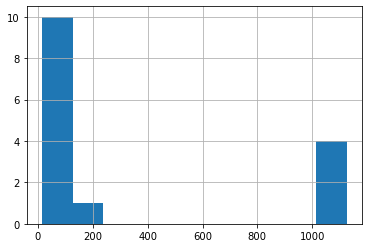

In [30]:
# Histogram for maximum_nights where maximum_nights is anomalous

seattle_list.loc[(seattle_list['minimum_nights'] == 6) & (seattle_list['maximum_nights'] < 10000)]['maximum_nights'].hist();

In [31]:
print("Median maximum_nights where minimum_nights is 6 = ",
      seattle_list.loc[(seattle_list['minimum_nights'] == 6) & 
                       (seattle_list['maximum_nights'] < 10000)]['maximum_nights'].median())

Median maximum_nights where minimum_nights is 6 =  32.0


We can replace the maximum_nights with 32

In [32]:
seattle_list.loc[seattle_list['id'] == 7440415, 'maximum_nights'] = 32

## Exploration

### Exploration 1 - Exploration of numeric variables

C:\Users\amanc\AppData\Local\Temp/ipykernel_20640/1703307345.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  seattle_list.hist(ax = ax);


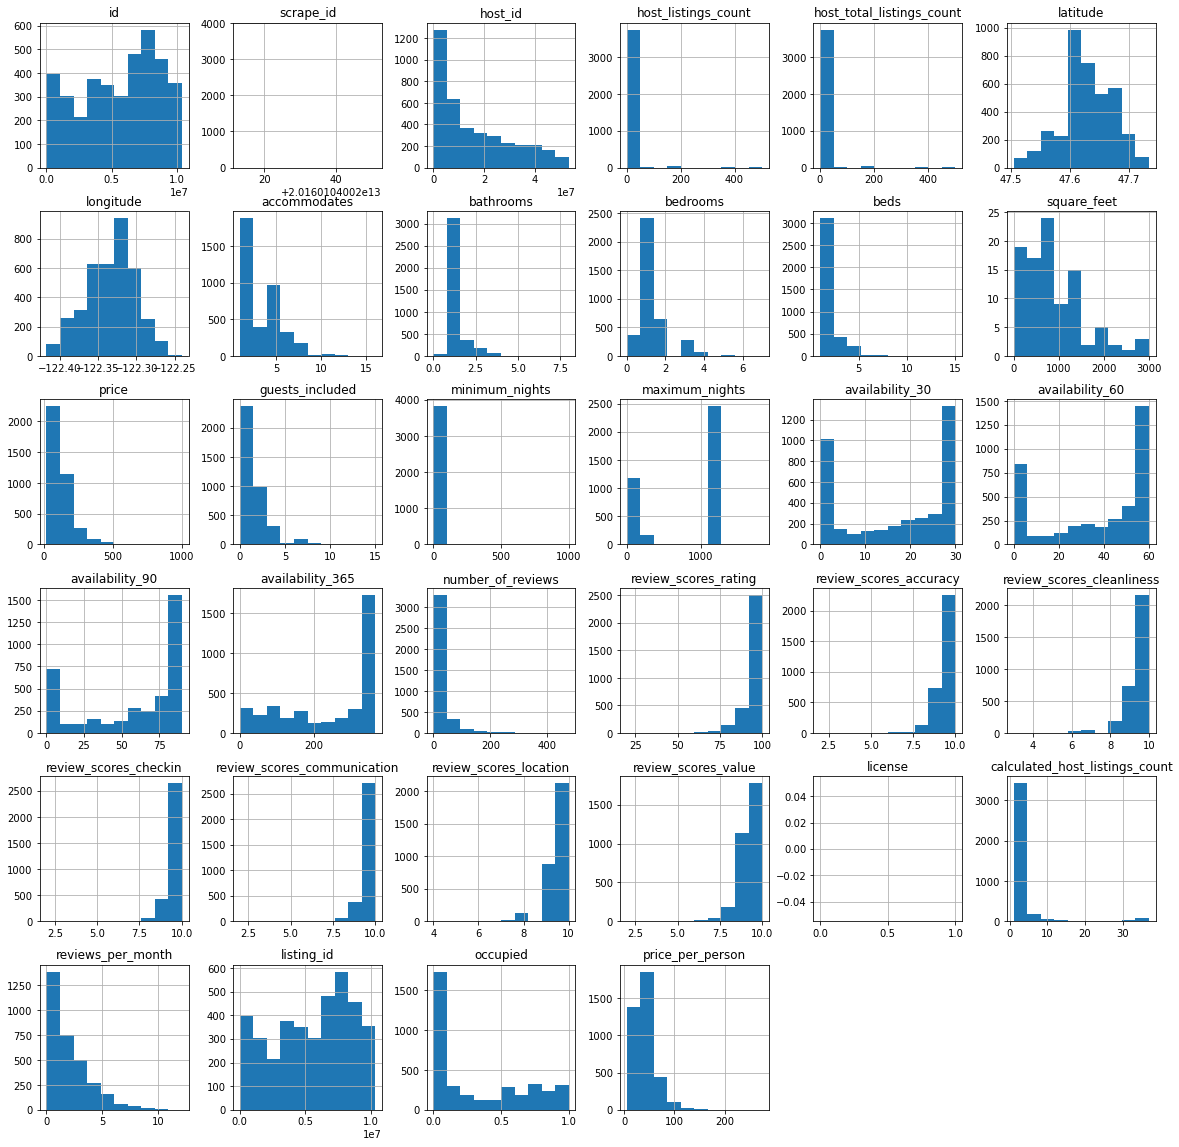

In [33]:
fig = plt.figure(figsize = (20,20));
ax = fig.gca();
seattle_list.hist(ax = ax);

### Outcome

1. 'Latitude' and 'Longitude' are more normally distributed as compared to other numeric variables
2. Variables describing space in property such as 'bathrooms', 'bedrooms', 'accomodates', 'beds', 'guests_included' are right skewed as majority of property are smaller in size and bigger property are niche and their availability decreases
3. Review Scores columns are left skewed towards maximum scores means people tend to review toward higher side
4. Price is also right skewed

### Exploration 2 - Exploration of correlation between price and other variable

Now let's look at relationship of numeric variables with Price by plotting correlation matrix

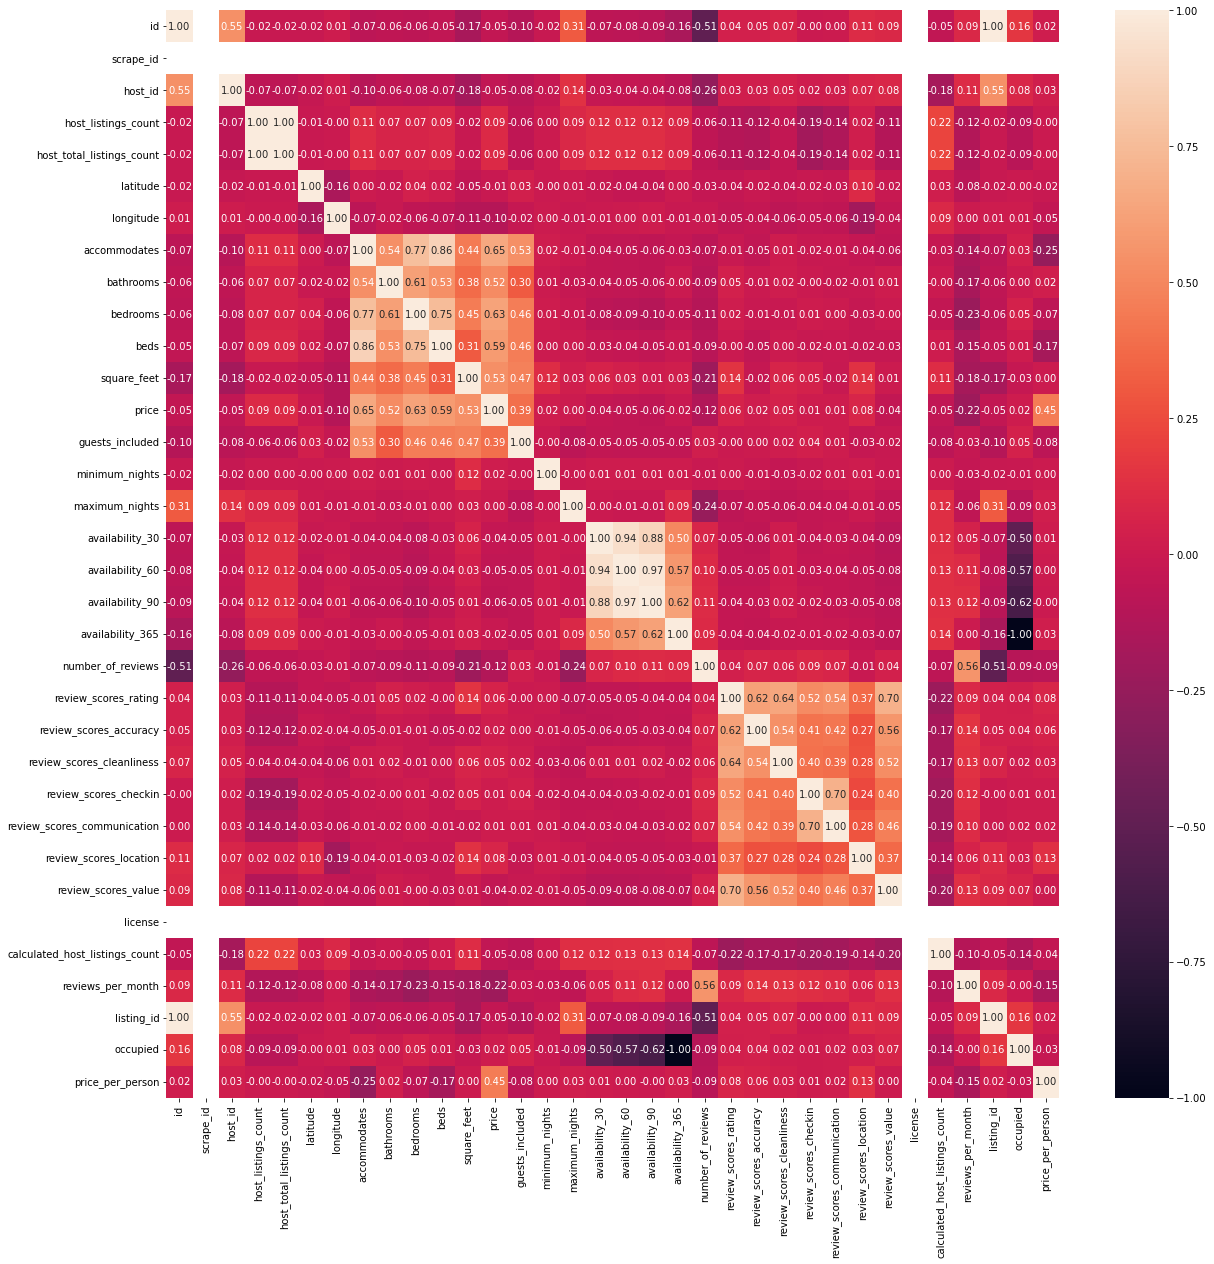

In [34]:
fig = plt.figure(figsize = (20,20));
ax = fig.gca();
sns.heatmap(seattle_list.corr(), annot=True, fmt=".2f",ax=ax);

### Outcome 2

Following numeric columns seem to have strong correlation with price. (based on absolute correlation greater than 0.05) 

1. 'accommodates'
2. 'bathrooms'
3. 'bedrooms'
4. 'beds'
5. 'square_feet'
6. 'guests_included'
7. 'number_of_reviews'
8. 'availability_60'
9. 'availability_90'
10. 'review_score_rating'
11. 'review_score_cleanliness'
12. 'review_score_location'
13. 'calculated_host_listings_count'
14. 'review_per_month'

### Exploration 3 - Categorical variables

Let's explore some categorical variables that can have impact on the price such as 

 
1. 'property_type'
2. 'room_type'
3. 'bed_type'
4. 'cancellation_policy'
5. 'city'
6. 'is_location_exact'
7. 'require_guest_profile_picture'
8. 'require_guest_phone_verification'
9. 'amenities'

#### variable 1 - property_type

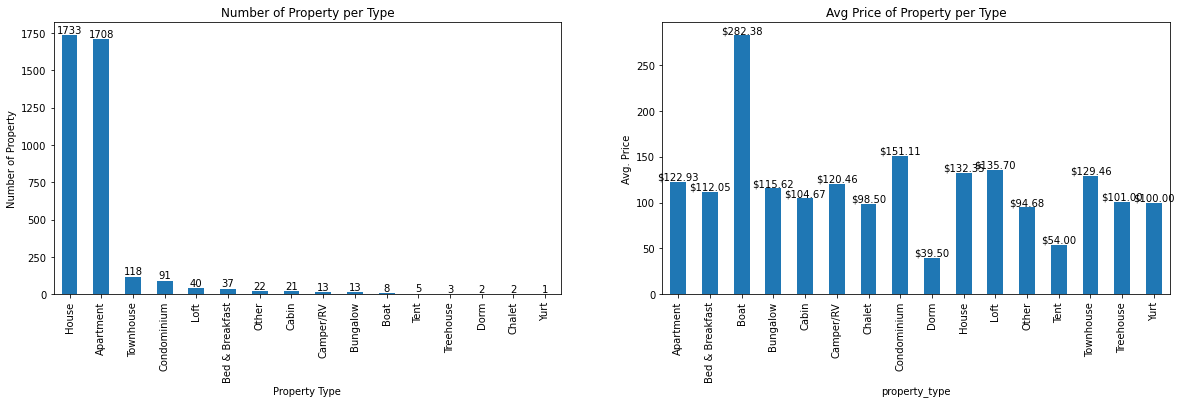

In [35]:
fig = plt.figure(figsize = (20,5))

# Plot 1 - Value count split
plt.subplot(1,2,1)
plt.title('Number of Property per Type')
plt.ylabel('Number of Property')
plt.xlabel('Property Type')
ax = seattle_list.property_type.value_counts().plot(kind='bar')

for container in ax.containers:
    ax.bar_label(container)
    
    
    
# Plot 2 - Mean Price distribution
plt.subplot(1,2,2)
plt.title('Avg Price of Property per Type')
plt.ylabel('Avg. Price')
plt.xlabel('Property Type')
ax2 = seattle_list.groupby(['property_type'])['price'].mean().plot(kind='bar')

for container in ax2.containers: 
    ax2.bar_label(container, labels=[f'${x:.2f}' for x in container.datavalues])

Let's look at occupancy level as well for each graph.

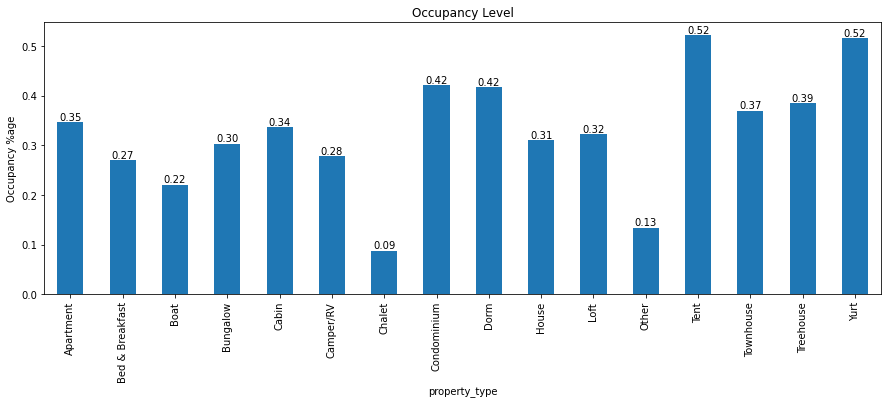

In [36]:
fig = plt.figure(figsize = (15,5))

plt.title('Occupancy Level')
plt.ylabel('Occupancy %age')
plt.xlabel('Property Type')

ax2 = seattle_list.groupby(['property_type'])['occupied'].mean().plot(kind='bar')

for container in ax2.containers: 
    ax2.bar_label(container, labels=[f'{x:.2f}' for x in container.datavalues])

### Insight 2

<i>property_type</i> is skewed towards 2 values - House and Apartment.

<i>property_type</i> shows low price difference between two most common types.


Tent and Dorm offer cheapest prices and are occupied the most, yet such type of properties are limited if we see the volume graph.

This means their demand exceeds the supply in comparison to other property type, hence the business opportunity.

#### variable 2 - room_type

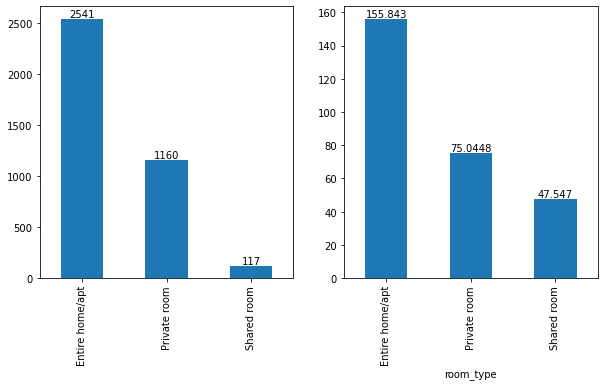

In [37]:
fig = plt.figure(figsize = (10,5))

# Plot 1 - Value count split
plt.subplot(1,2,1)
ax = seattle_list.room_type.value_counts().plot(kind='bar')

for container in ax.containers:
    ax.bar_label(container)
    
    
    
# Plot 2 - Mean Price distribution
plt.subplot(1,2,2)
ax2 = seattle_list.groupby(['room_type'])['price'].mean().plot(kind='bar')

for container in ax2.containers:
    ax2.bar_label(container)

<i>room_type</i> shows price variation for all values which means that it can act as good variable in price predition

#### variable 3 - bed_type

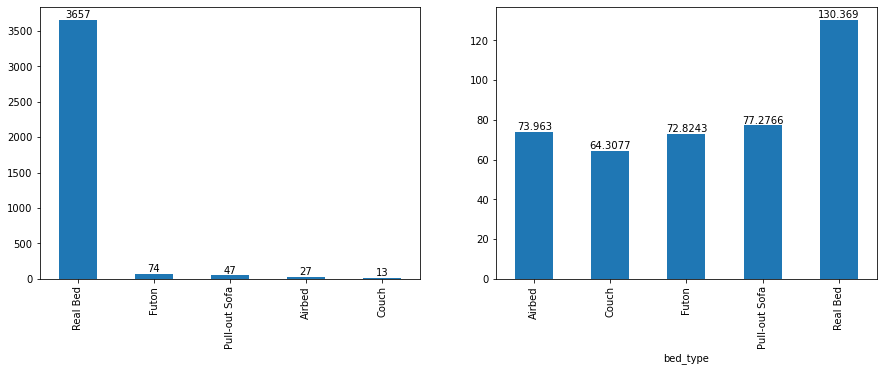

In [38]:
fig = plt.figure(figsize = (15,5))

# Plot 1 - Value count split
plt.subplot(1,2,1)
ax = seattle_list.bed_type.value_counts().plot(kind='bar')

for container in ax.containers:
    ax.bar_label(container)
    
    
    
# Plot 2 - Mean Price distribution
plt.subplot(1,2,2)
ax2 = seattle_list.groupby(['bed_type'])['price'].mean().plot(kind='bar')

for container in ax2.containers:
    ax2.bar_label(container)

<i>bed_type</i> shows price variation for all values which means that it can act as good variable in price predition

#### variable 4 - cancellation_policy

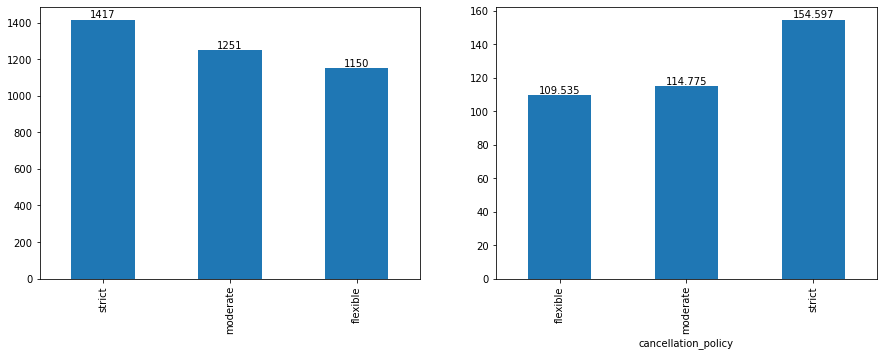

In [39]:
fig = plt.figure(figsize = (15,5))

# Plot 1 - Value count split
plt.subplot(1,2,1)
ax = seattle_list.cancellation_policy.value_counts().plot(kind='bar')

for container in ax.containers:
    ax.bar_label(container)
    
    
    
# Plot 2 - Mean Price distribution
plt.subplot(1,2,2)
ax2 = seattle_list.groupby(['cancellation_policy'])['price'].mean().plot(kind='bar')

for container in ax2.containers:
    ax2.bar_label(container)

<i>cancellation_policy</i> shows price variation for all values which means that it can act as good variable in price predition

#### variable 5 - city

C:\Users\amanc\miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 35199 (\N{CJK UNIFIED IDEOGRAPH-897F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\amanc\miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 38597 (\N{CJK UNIFIED IDEOGRAPH-96C5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\amanc\miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


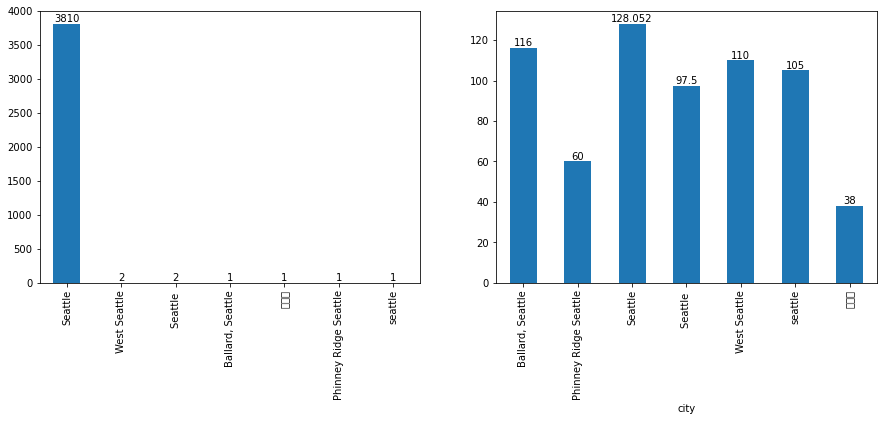

In [40]:
fig = plt.figure(figsize = (15,5));

# Plot 1 - Value count split
plt.subplot(1,2,1);
ax = seattle_list.city.value_counts().plot(kind='bar');

for container in ax.containers:
    ax.bar_label(container);
    
    
    
# Plot 2 - Mean Price distribution
plt.subplot(1,2,2);
ax2 = seattle_list.groupby(['city'])['price'].mean().plot(kind='bar');

for container in ax2.containers:
    ax2.bar_label(container);

<i>city</i> is highly skewed toward Seattle. Not a good indicator for price prediction.

#### variable 6 - is_location_exact

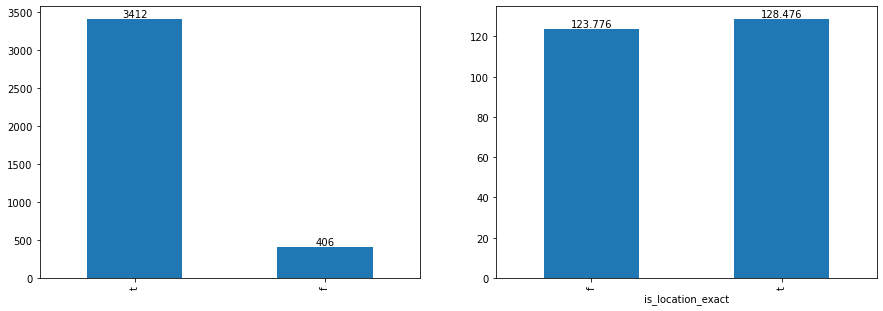

In [41]:
fig = plt.figure(figsize = (15,5));

# Plot 1 - Value count split
plt.subplot(1,2,1);
ax = seattle_list.is_location_exact.value_counts().plot(kind='bar');

for container in ax.containers:
    ax.bar_label(container);
    
    
    
# Plot 2 - Mean Price distribution
plt.subplot(1,2,2);
ax2 = seattle_list.groupby(['is_location_exact'])['price'].mean().plot(kind='bar');

for container in ax2.containers:
    ax2.bar_label(container);

<i>is_location_exact</i> show very less price variation for 'true' or 'false'. Not a good indicator for price prediction.

#### variable 7 - require_guest_profile_picture

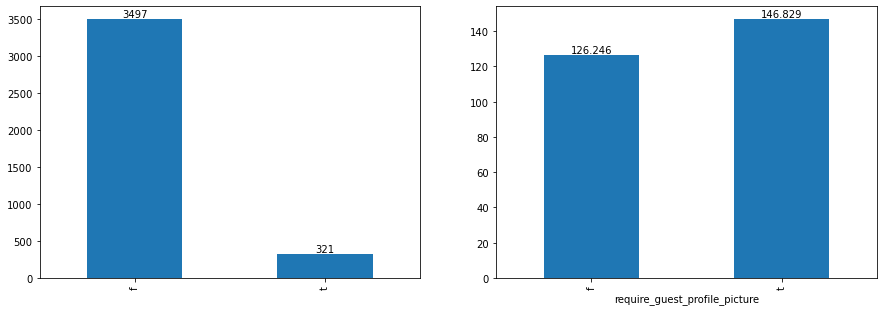

In [42]:
fig = plt.figure(figsize = (15,5));

# Plot 1 - Value count split
plt.subplot(1,2,1);
ax = seattle_list.require_guest_profile_picture.value_counts().plot(kind='bar');

for container in ax.containers:
    ax.bar_label(container);
    
    
    
# Plot 2 - Mean Price distribution
plt.subplot(1,2,2);
ax2 = seattle_list.groupby(['require_guest_profile_picture'])['price'].mean().plot(kind='bar');

for container in ax2.containers:
    ax2.bar_label(container);

#### variable 8 - require_guest_phone_verification

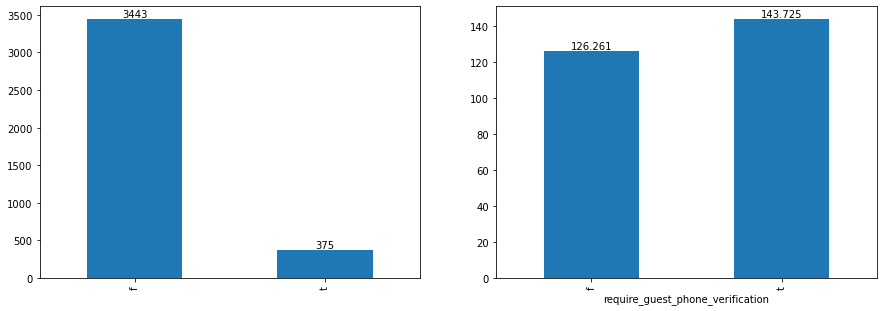

In [43]:
fig = plt.figure(figsize = (15,5));

# Plot 1 - Value count split
plt.subplot(1,2,1);
ax = seattle_list.require_guest_phone_verification.value_counts().plot(kind='bar');

for container in ax.containers:
    ax.bar_label(container);
    
    
    
# Plot 2 - Mean Price distribution
plt.subplot(1,2,2);
ax2 = seattle_list.groupby(['require_guest_phone_verification'])['price'].mean().plot(kind='bar');

for container in ax2.containers:
    ax2.bar_label(container);

### Insight 3


<i>require_guest_profile_picture</i> and <i>require_guest_phone_verification</i> show some price variation for 'true' or 'false'. Can act as a good indicator for price prediction however logically thinking this variable means that property having higher price seem to be peciluar about authentic customers. Here correlation between this variable and price does not imply causation.

Means property with higher value seem to require guest to have profile picture but reverse cannot be assumed to be true. Property requiring guest profile cannot just ask for higher price because of this variable. so this variable would not be used for price prediction.

#### variable 9 - amenities

<i>amenities</i> column have all values stored in commas

Let's pull all unique amenities values from column

In [44]:
amenities_list = list()

length = seattle_list.shape[0]


for i in range(length):
    lst = seattle_list.amenities[i].replace('"','').replace('{','').replace('}','').split(',')
    amenities_list.extend(lst)

    
amenities_list_unique = list(np.unique(np.array(amenities_list)))
print(amenities_list_unique)

['', '24-Hour Check-in', 'Air Conditioning', 'Breakfast', 'Buzzer/Wireless Intercom', 'Cable TV', 'Carbon Monoxide Detector', 'Cat(s)', 'Dog(s)', 'Doorman', 'Dryer', 'Elevator in Building', 'Essentials', 'Family/Kid Friendly', 'Fire Extinguisher', 'First Aid Kit', 'Free Parking on Premises', 'Gym', 'Hair Dryer', 'Hangers', 'Heating', 'Hot Tub', 'Indoor Fireplace', 'Internet', 'Iron', 'Kitchen', 'Laptop Friendly Workspace', 'Lock on Bedroom Door', 'Other pet(s)', 'Pets Allowed', 'Pets live on this property', 'Pool', 'Safety Card', 'Shampoo', 'Smoke Detector', 'Smoking Allowed', 'Suitable for Events', 'TV', 'Washer', 'Washer / Dryer', 'Wheelchair Accessible', 'Wireless Internet']


In [45]:
# creating variable for each amenities

amenities_df = seattle_list[['id', 'price', 'amenities']]

amenities_col_list = list()

for amenity in amenities_list_unique[1:]:
    col_name = "amenity_" + amenity.replace(" ","_")
    amenities_col_list.append(col_name)
    amenities_df[col_name] = seattle_list['amenities'].apply(lambda x: 1 if amenity in x else 0)

C:\Users\amanc\AppData\Local\Temp/ipykernel_20640/994237498.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amenities_df[col_name] = seattle_list['amenities'].apply(lambda x: 1 if amenity in x else 0)
C:\Users\amanc\AppData\Local\Temp/ipykernel_20640/994237498.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amenities_df[col_name] = seattle_list['amenities'].apply(lambda x: 1 if amenity in x else 0)
C:\Users\amanc\AppData\Local\Temp/ipykernel_20640/994237498.py:10: SettingWithCopyWarning: 
A value 

C:\Users\amanc\AppData\Local\Temp/ipykernel_20640/994237498.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amenities_df[col_name] = seattle_list['amenities'].apply(lambda x: 1 if amenity in x else 0)
C:\Users\amanc\AppData\Local\Temp/ipykernel_20640/994237498.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amenities_df[col_name] = seattle_list['amenities'].apply(lambda x: 1 if amenity in x else 0)
C:\Users\amanc\AppData\Local\Temp/ipykernel_20640/994237498.py:10: SettingWithCopyWarning: 
A value 

C:\Users\amanc\AppData\Local\Temp/ipykernel_20640/994237498.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amenities_df[col_name] = seattle_list['amenities'].apply(lambda x: 1 if amenity in x else 0)


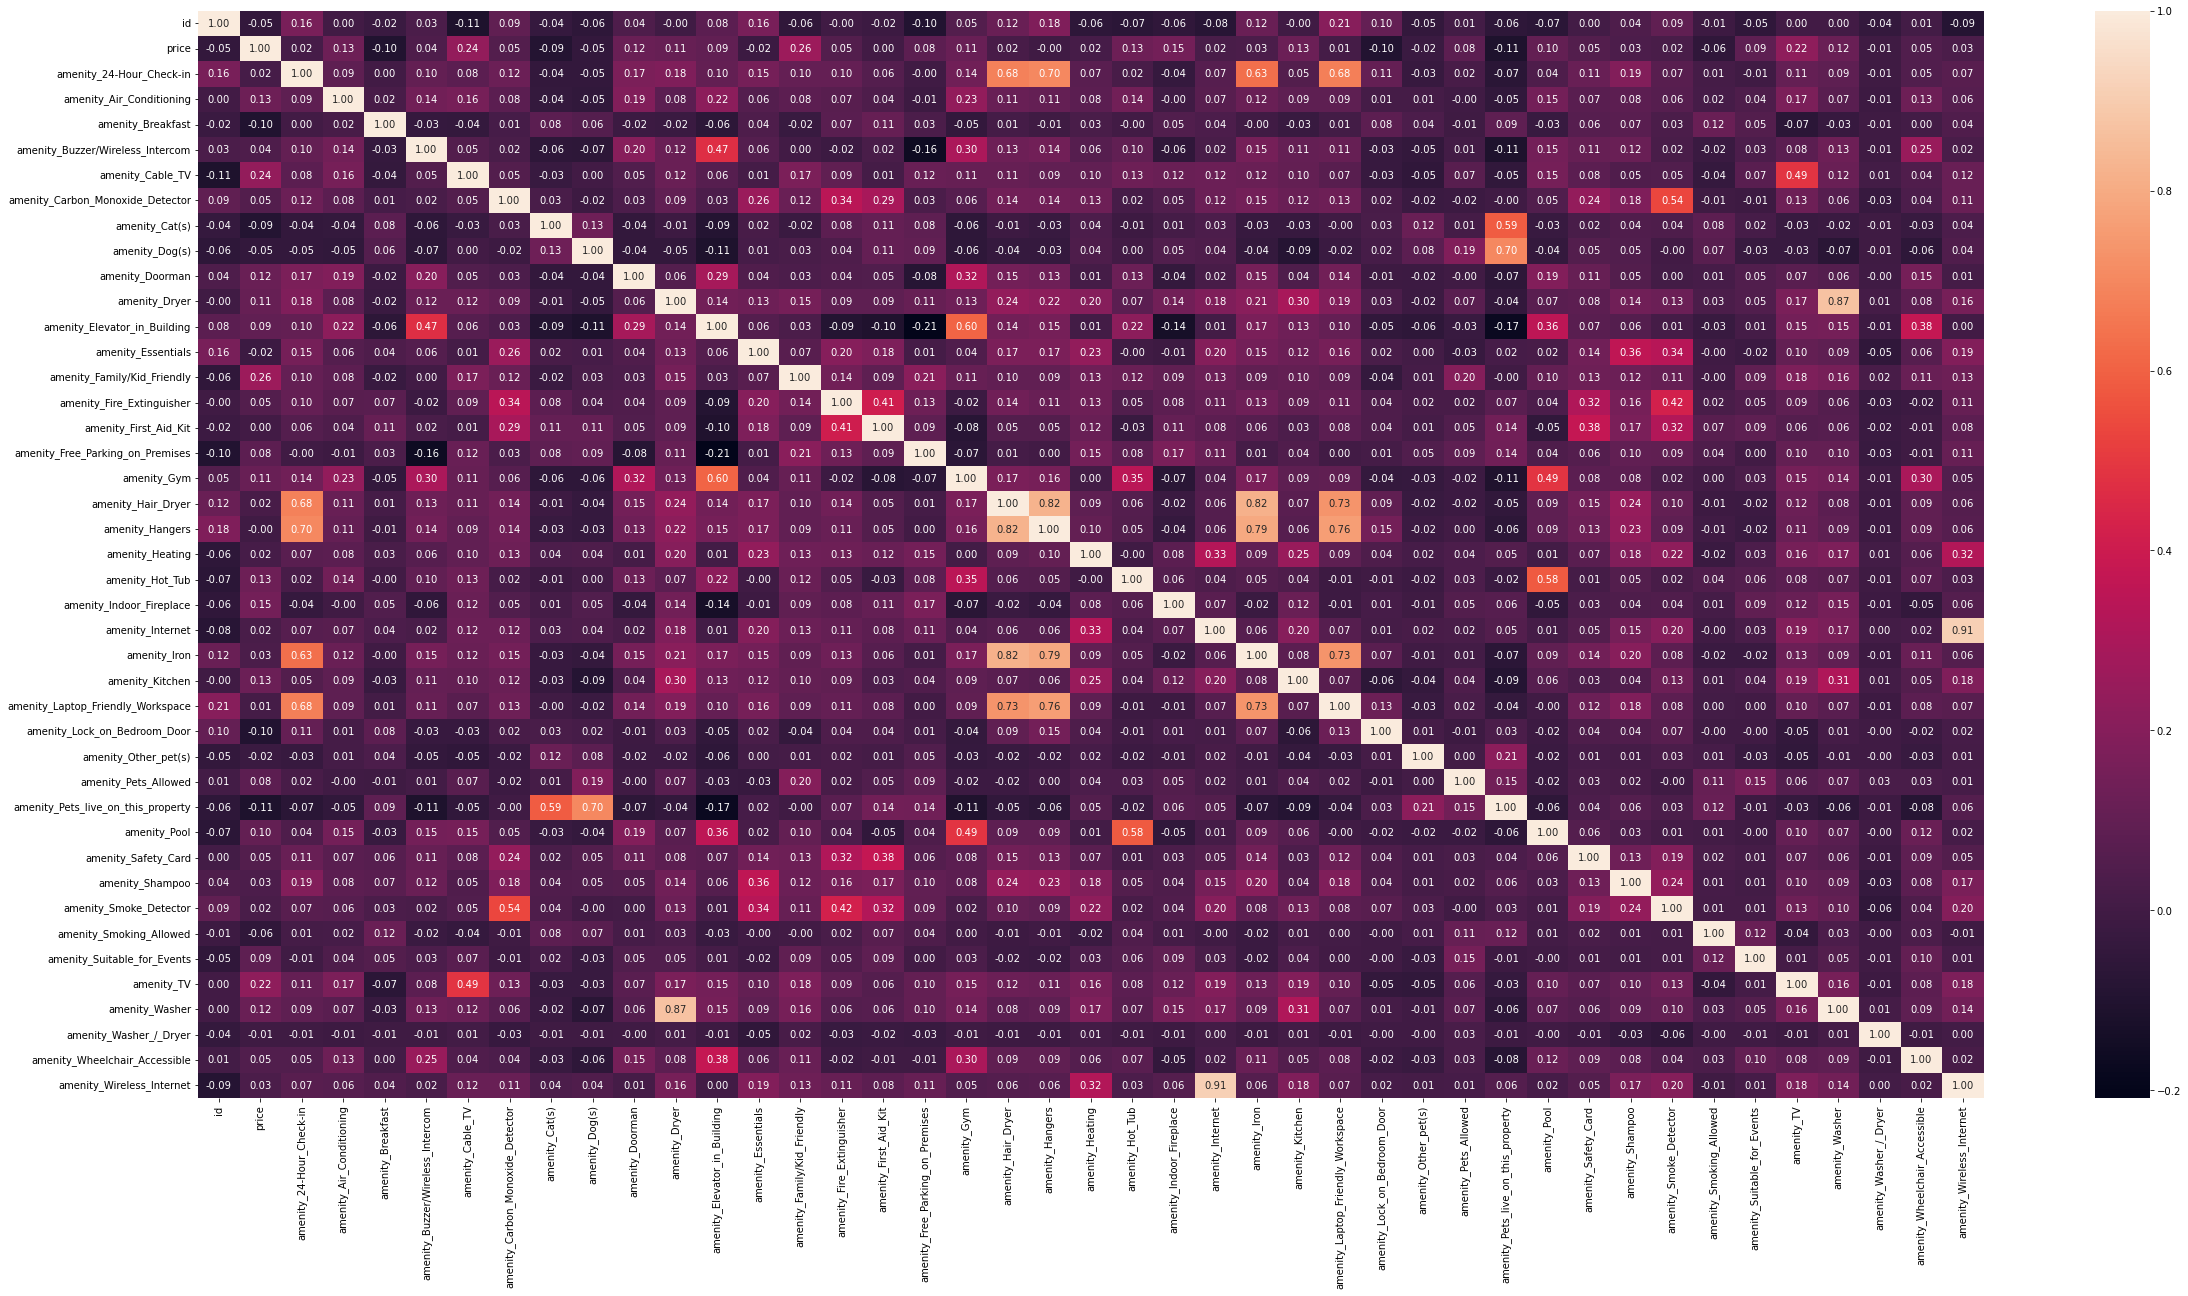

In [46]:
# amenities_df correlation matrix


fig = plt.figure(figsize = (40,20));
ax = fig.gca();
sns.heatmap(amenities_df.corr(), annot=True, fmt=".2f",ax=ax);

### Insight 4

#### Following amenities have highest correlation with price.

- 'amenity_Cable_TV'
- 'amenity_Family/Kid_Friendly'
- 'amenity_TV'
- 'amenity_indoor_Fireplace'
- 'amenity_Air_Conditioning'
- 'amenity_Hot_Tub'
- 'amenity_Kitchen'

### Airbnb Density in Seattle Location

Below map can be used to explore density at each location and it can be zoomed in or out as well.

In [47]:
print(seattle_list.longitude.mean())
print(seattle_list.latitude.mean())

-122.3331032929215
47.62896083310483


In [48]:
hmap = Map(location=[47.628960833104735, -122.33310329292141], zoom_start=10,)

hm_wide = HeatMap(
    list(zip(seattle_list.latitude.values, seattle_list.longitude.values)),
    min_opacity=0.2,
    radius=10, 
    blur=7, 
    max_zoom=1,
)
hmap.add_child(hm_wide)

## Model Development

Let's start with picking smaller set of relevant columns

I am removing some columns which may not have any impact on price as we are interested in price prediction model such as <i>availability_30</i>, <i>availability_90</i>, <i>city</i>, <i>is_location_exact</i>, <i>require_guest_profile_picture</i> and <i>require_guest_phone_verification</i>.

From amenities list, lets pick top 7 amenities only as so many columns can lead to overfitting of model.

Top 7 amenities with strongest correlation with prices are
- 'amenity_Cable_TV'
- 'amenity_Family/Kid_Friendly'
- 'amenity_TV'
- 'amenity_indoor_Fireplace'
- 'amenity_Air_Conditioning'
- 'amenity_Hot_Tub'
- 'amenity_Kitchen'

In [49]:
seattle_list_mod = seattle_list[['id',
                                 'price',
                                 'accommodates',
                                 'bathrooms',
                                 'bedrooms',
                                 'beds',
                                 'guests_included',
                                 'number_of_reviews',
                                 'review_scores_rating',
                                 'review_scores_cleanliness',
                                 'review_scores_location',
                                 'calculated_host_listings_count',
                                 'property_type',
                                 'room_type',
                                 'bed_type',
                                 'occupied',
                                 'cancellation_policy',
                                 'reviews_per_month',
                                 'price_per_person']]

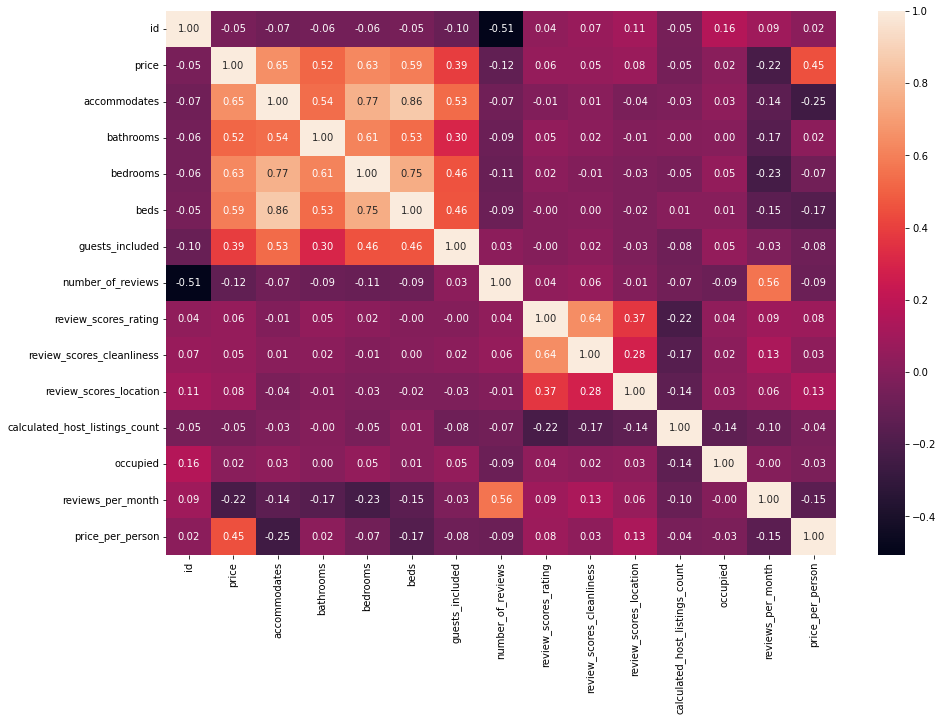

In [50]:
fig = plt.figure(figsize = (15,10));
ax = fig.gca();
sns.heatmap(seattle_list_mod.corr(), annot=True, fmt=".2f",ax=ax);

In [51]:
seattle_list_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3818 non-null   int64  
 1   price                           3818 non-null   float64
 2   accommodates                    3818 non-null   int64  
 3   bathrooms                       3802 non-null   float64
 4   bedrooms                        3812 non-null   float64
 5   beds                            3817 non-null   float64
 6   guests_included                 3818 non-null   int64  
 7   number_of_reviews               3818 non-null   int64  
 8   review_scores_rating            3171 non-null   float64
 9   review_scores_cleanliness       3165 non-null   float64
 10  review_scores_location          3163 non-null   float64
 11  calculated_host_listings_count  3818 non-null   int64  
 12  property_type                   38

Adding Amenities column to dataframe

In [52]:
amenities_df_mod = amenities_df[['id',
                                'amenity_Cable_TV',
                                'amenity_Family/Kid_Friendly',
                                'amenity_TV',
                                'amenity_Indoor_Fireplace',
                                'amenity_Air_Conditioning',
                                'amenity_Hot_Tub',
                                'amenity_Kitchen']]

seattle_list_mod = seattle_list_mod.merge(amenities_df_mod,how='left', left_on='id',right_on='id')

In [53]:
seattle_list_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3818 non-null   int64  
 1   price                           3818 non-null   float64
 2   accommodates                    3818 non-null   int64  
 3   bathrooms                       3802 non-null   float64
 4   bedrooms                        3812 non-null   float64
 5   beds                            3817 non-null   float64
 6   guests_included                 3818 non-null   int64  
 7   number_of_reviews               3818 non-null   int64  
 8   review_scores_rating            3171 non-null   float64
 9   review_scores_cleanliness       3165 non-null   float64
 10  review_scores_location          3163 non-null   float64
 11  calculated_host_listings_count  3818 non-null   int64  
 12  property_type                   38

In [54]:
seattle_list_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3818 non-null   int64  
 1   price                           3818 non-null   float64
 2   accommodates                    3818 non-null   int64  
 3   bathrooms                       3802 non-null   float64
 4   bedrooms                        3812 non-null   float64
 5   beds                            3817 non-null   float64
 6   guests_included                 3818 non-null   int64  
 7   number_of_reviews               3818 non-null   int64  
 8   review_scores_rating            3171 non-null   float64
 9   review_scores_cleanliness       3165 non-null   float64
 10  review_scores_location          3163 non-null   float64
 11  calculated_host_listings_count  3818 non-null   int64  
 12  property_type                   38

## Model Development

### Treating missing values

In [55]:
seattle_list_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3818 non-null   int64  
 1   price                           3818 non-null   float64
 2   accommodates                    3818 non-null   int64  
 3   bathrooms                       3802 non-null   float64
 4   bedrooms                        3812 non-null   float64
 5   beds                            3817 non-null   float64
 6   guests_included                 3818 non-null   int64  
 7   number_of_reviews               3818 non-null   int64  
 8   review_scores_rating            3171 non-null   float64
 9   review_scores_cleanliness       3165 non-null   float64
 10  review_scores_location          3163 non-null   float64
 11  calculated_host_listings_count  3818 non-null   int64  
 12  property_type                   38

##### bathrooms

In [56]:
# Bathroom can be dependent on bedroom.

seattle_list_mod['bathrooms'] = seattle_list_mod['bathrooms'].fillna(seattle_list_mod.groupby(['bedrooms'])['bathrooms'].transform('mean'))

##### bedrooms

In [57]:
# bedroom can be dependent on bathroom.

seattle_list_mod['bedrooms'] = seattle_list_mod['bedrooms'].fillna(seattle_list_mod.groupby(['bathrooms'])['bedrooms'].transform('mean'))

##### beds

In [58]:
# bedroom can be dependent on bathroom.

seattle_list_mod['beds'] = seattle_list_mod['beds'].fillna(seattle_list_mod.groupby(['bedrooms'])['beds'].transform('mean'))

##### review_scores_rating

In [59]:
seattle_list_mod['review_scores_rating'] = seattle_list_mod['review_scores_rating'].fillna(seattle_list_mod['review_scores_rating'].mean())

##### review_scores_cleanliness

In [60]:
seattle_list_mod['review_scores_cleanliness'] = seattle_list_mod['review_scores_cleanliness'].fillna(seattle_list_mod['review_scores_rating'].mean())

##### review_scores_location

In [61]:
seattle_list_mod['review_scores_location'] = seattle_list_mod['review_scores_location'].fillna(seattle_list_mod['review_scores_rating'].mean())

##### property_type

In [62]:
seattle_list_mod.loc[seattle_list_mod.property_type.isna(), 'property_type'] = 'Other'

##### reviews_per_month

In [63]:
# bedroom can be dependent on bathroom.

seattle_list_mod['reviews_per_month'] = seattle_list_mod['reviews_per_month'].fillna(seattle_list_mod.groupby(['property_type'])['reviews_per_month'].transform('mean'))

In [64]:
seattle_list_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3818 non-null   int64  
 1   price                           3818 non-null   float64
 2   accommodates                    3818 non-null   int64  
 3   bathrooms                       3818 non-null   float64
 4   bedrooms                        3818 non-null   float64
 5   beds                            3818 non-null   float64
 6   guests_included                 3818 non-null   int64  
 7   number_of_reviews               3818 non-null   int64  
 8   review_scores_rating            3818 non-null   float64
 9   review_scores_cleanliness       3818 non-null   float64
 10  review_scores_location          3818 non-null   float64
 11  calculated_host_listings_count  3818 non-null   int64  
 12  property_type                   38

### Converting Categorical variables into numeric variable using dummy variables method

In [65]:
#Create a copy of the dataframe
seattle_list_mod_copy = seattle_list_mod.copy()

#Pull a list of the column names of the categorical variables
cat_cols_lst = ['cancellation_policy','property_type','room_type','bed_type']

In [66]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    
    for col in cat_cols:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_',drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue

    return df

In [67]:
seattle_list_mod_new = create_dummy_df(seattle_list_mod_copy,cat_cols_lst,dummy_na=False)

In [68]:
seattle_list_mod.shape

(3818, 26)

In [69]:
seattle_list_mod_new.shape

(3818, 45)

In [70]:
pd.options.display.max_columns = seattle_list_mod_new.shape[1]
seattle_list_mod_new

,id,price,accommodates,bathrooms,bedrooms,beds,guests_included,number_of_reviews,review_scores_rating,review_scores_cleanliness,review_scores_location,calculated_host_listings_count,occupied,reviews_per_month,price_per_person,amenity_Cable_TV,amenity_Family/Kid_Friendly,amenity_TV,amenity_Indoor_Fireplace,amenity_Air_Conditioning,amenity_Hot_Tub,amenity_Kitchen,cancellation_policy_moderate,cancellation_policy_strict,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,241032,85.0,4,1.0,1.0,1.0,2,207,95.000000,10.000000,9.000000,2,0.052055,4.070000,21.250000,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,953595,150.0,4,1.0,1.0,1.0,1,43,96.000000,10.000000,10.000000,6,0.202740,1.480000,37.500000,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3308979,975.0,11,4.5,5.0,7.0,10,20,97.000000,10.000000,10.000000,2,0.397260,1.150000,88.636364,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,7421966,100.0,3,1.0,0.0,2.0,1,0,94.539262,94.539262,94.539262,1,0.608219,2.117213,33.333333,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,278830,450.0,6,2.0,3.0,3.0,6,38,92.000000,9.000000,9.000000,1,0.000000,0.890000,75.000000,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,359.0,6,2.0,3.0,3.0,1,1,80.000000,10.000000,10.000000,8,0.912329,0.300000,59.833333,1,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3814,8902327,79.0,4,1.0,1.0,2.0,3,2,100.000000,10.000000,10.000000,1,0.252055,2.000000,19.750000,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3815,10267360,93.0,2,1.0,1.0,1.0,2,0,94.539262,94.539262,94.539262,1,0.758904,1.999686,46.500000,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3816,9604740,99.0,2,1.0,0.0,1.0,1,0,94.539262,94.539262,94.539262,1,0.509589,1.804348,49.500000,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


##### Create X and y for modelling

In [71]:
X = seattle_list_mod_new.drop(['id','price'], axis=1)
y = seattle_list_mod_new['price']

In [72]:
print(X.shape)
print(y.shape)

(3818, 43)
(3818,)


##### Split dataset into Train and Test dataset

In [73]:
test_size=.25
rand_state=42

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=rand_state)

In [74]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2863, 43)
(955, 43)
(2863,)
(955,)


##### Fitting the model

In [75]:
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)

LinearRegression()

### Evaluating the model

#### Evaluation 1 using R Square method

In [76]:
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

In [77]:
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

In [78]:
print(test_score)
print(train_score)

0.8479717730016537
0.8358877578096402


#### Evaluation 2 using Adjusted R Square method

In [79]:
Adj_r2 = 1 - (1-r2_score(y_test, y_test_preds)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print(Adj_r2)

0.8462396018938294


#### Evaluation 3 using Mean Absolute Error(MAE)

In [80]:
print(mean_absolute_error(y_test, y_test_preds))
print(mean_absolute_error(y_train, y_train_preds))

20.55560112371132
20.140223999546954


#### Evaluation 4 using Mean Square Error(MSE)/Root Mean Square Error(RMSE)

In [81]:
print("For Test set")
print(mean_squared_error(y_test, y_test_preds))
print(math.sqrt(mean_squared_error(y_test, y_test_preds)))

print("For Train set")
print(mean_squared_error(y_train, y_train_preds))
print(math.sqrt(mean_squared_error(y_train, y_train_preds)))

For Test set
1270.0022400988335
35.63709079174159
For Train set
1324.739263085936
36.396967773235396


Evaluation gives satisfactory result and this model can be used for evaluation of prices